## Import packets

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sn
import networkx as nx
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import from_networkx
from torch_geometric.data import InMemoryDataset

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## GNN(s)

In [2]:
class GNN2L_GAT (nn.Module):
    def __init__(self, data):
        super().__init__()
        self.conv1 = GATv2Conv(data.num_features, 16, dropout=0.3)
        self.conv2 = GATv2Conv(16, int(data.num_classes))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

class GNN4L_GAT (nn.Module):
    def __init__(self, data):
        super().__init__()
        self.conv1 = GATv2Conv(data.num_features, 16)
        self.conv2 = GATv2Conv(16, 16)
        self.conv3 = GATv2Conv(16, 16)
        self.conv4 = GATv2Conv(16, int(data.num_classes), dropout=0.3)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

## Dataset loader

In [3]:
# Dataset class: it allows to translate a vector (Graph, Attributes, Labels)
# into a dataset compatible with the PyTorch models.
# 
# Parameters:
# - G: NetworkX graph
# - Labels: of the nodes used for classification
# - attributes: List of the nodes' attributes

class MyDataset(InMemoryDataset):
  def __init__(self, G, labels, attributes = None, num_classes = 2, balance = False, debug = False):
    super(MyDataset, self).__init__('.', None, None, None)

    # import data from the networkx graph with the attributes of the nodes
    data = from_networkx(G, attributes)
      
    y = torch.from_numpy(labels).type(torch.long)

    data.x = data.x.float()
    data.y = y.clone().detach()
    data.num_classes = num_classes

    # Using train_test_split function from sklearn to stratify train/test/val sets
    indices = range(G.number_of_nodes())
    # Stratified split of train/test/val sets. Returned indices are used to create the masks
    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(data.x, data.y, indices, test_size=0.3, stratify=labels)
    # To create validation set, test set is splitted in half
    X_test, X_val, y_test, y_val, test_idx, val_idx = train_test_split(X_test, y_test, test_idx, test_size=0.5, stratify=y_test)

    n_nodes = G.number_of_nodes()
    train_mask  = torch.zeros(n_nodes, dtype=torch.bool)
    test_mask   = torch.zeros(n_nodes, dtype=torch.bool)
    val_mask    = torch.zeros(n_nodes, dtype=torch.bool)

    dataframe = pd.read_csv('Datasets/C0006142_Malignant_neoplasm_of_breast_features.csv')
    dataframe = dict(zip(dataframe['name'], dataframe['class']))
    nodes_list = list(G.nodes)

    if not balance:
      for idx in train_idx:
        train_mask[idx] = True

      for idx in test_idx:
        test_mask[idx] = True
      
      for idx in val_idx:
        val_mask[idx] = True
    else:
      # BALANCING THE TRAINING DATASET
      # count the positive/negative nodes in the training mask
      positive_nodes_in_train = 0
      negative_nodes_in_train = 0
      for idx in train_idx:
        if dataframe[nodes_list[idx]]:
          positive_nodes_in_train += 1
        else:
          negative_nodes_in_train += 1
      
      positive_nodes_in_test = 0
      negative_nodes_in_test = 0
      for idx in test_idx:
        if dataframe[nodes_list[idx]]:
          positive_nodes_in_test += 1
        else:
          negative_nodes_in_test += 1
      
      positive_nodes_in_val = 0
      negative_nodes_in_val = 0
      for idx in val_idx:
        if dataframe[nodes_list[idx]]:
          positive_nodes_in_val += 1
        else:
          negative_nodes_in_val += 1

      # not adding the first (#negative - #positive) negative samples
      n_unbalanced_samples_train = negative_nodes_in_train - positive_nodes_in_train
      c = 0

      for idx in train_idx:
        if dataframe[nodes_list[idx]]:
          train_mask[idx] = True
        else:
          # add to train mask after n_unbalanced_samples_train skipped
          if c >= n_unbalanced_samples_train:
            train_mask[idx] = True
          c += 1
      
      n_unbalanced_samples_test = negative_nodes_in_test - positive_nodes_in_test
      c = 0

      for idx in test_idx:
        if dataframe[nodes_list[idx]]:
          test_mask[idx] = True
        else:
          # add to test mask after n_unbalanced_samples_test skipped
          if c >= n_unbalanced_samples_test:
            test_mask[idx] = True
          c += 1
      
      n_unbalanced_samples_val = negative_nodes_in_val - positive_nodes_in_val
      c = 0

      for idx in val_idx:
        if dataframe[nodes_list[idx]]:
          val_mask[idx] = True
        else:
          # add to val mask after n_unbalanced_samples_val skipped
          if c >= n_unbalanced_samples_val:
            val_mask[idx] = True
          c += 1
    
    # --- for debug purposes ---
    if debug:

      print('len train_idx:', len(train_idx))
      print('len test_idx:', len(test_idx))
      print('len val_idx:', len(val_idx))

      pos = 0
      neg = 0
      # let's see if the mask is now balanced
      for idx in train_idx:
        # if the idx has been added to the training mask
        if train_mask[idx]:
          if dataframe[nodes_list[idx]]:
            pos += 1
          else:
            neg += 1
      
      print('pos/neg in train mask:', pos, neg)
    
      pos = 0
      neg = 0
      # let's see if the mask is now balanced
      for idx in test_idx:
        # if the idx has been added to the testing mask
        if test_mask[idx]:
          if dataframe[nodes_list[idx]]:
            pos += 1
          else:
            neg += 1
      
      print('pos/neg in test mask:', pos, neg)

      pos = 0
      neg = 0
      # let's see if the mask is now balanced
      for idx in val_idx:
        # if the idx has been added to the validating mask
        if val_mask[idx]:
          if dataframe[nodes_list[idx]]:
            pos += 1
          else:
            neg += 1
      
      print('pos/neg in val mask:', pos, neg)

    data['train_mask']  = train_mask
    data['test_mask']   = test_mask
    data['val_mask']    = val_mask

    self.data, self.slices = self.collate([data])

## Training Function

In [4]:
def train(model, data, epochs = 200, classes = ['0','1'], lr = 0.001, cm_title = 'GNN'):
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    train_mask  = data['train_mask']
    test_mask   = data['test_mask']
    val_mask    = data['val_mask']

    labels    = data.y
    output = ''

    # list to plot the train accuracy
    train_acc_curve = []
    train_lss_curve = []

    best_train_acc  = 0
    best_val_acc    = 0
    best_test_acc   = 0

    for e in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()
        logits      = model(data)
        output      = logits.argmax(1)
        # train_loss  = F.cross_entropy(logits[train_mask], labels[train_mask])
        train_loss  = F.nll_loss(logits[train_mask], labels[train_mask])
        train_acc   = (output[train_mask] == labels[train_mask]).float().mean()
        train_loss.backward()
        optimizer.step()

        # Append train acc. to plot curve later
        train_acc_curve.append(train_acc.item())
        train_lss_curve.append(train_loss.item())

        if train_acc > best_train_acc:
            best_train_acc = train_acc

        # Evaluation and test
        model.eval()
        logits      = model(data)
        output      = logits.argmax(1)
        # val_loss    = F.cross_entropy(logits[val_mask], labels[val_mask])
        val_loss    = F.nll_loss(logits[val_mask], labels[val_mask])
        val_acc     = (output[val_mask] == labels[val_mask]).float().mean()
        test_acc    = (output[test_mask] == labels[test_mask]).float().mean()

        # Update best test/val acc.
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc

        if e % 20 == 0 or e == epochs:
            print('[Epoch: {:04d}]'.format(e),
            'train loss: {:.4f},'.format(train_loss.item()),
            'train acc: {:.4f},'.format(train_acc.item()),
            'test acc: {:.4f},'.format(test_acc.item()),
            'val loss: {:.4f},'.format(val_loss.item()),
            'val acc: {:.4f} '.format(val_acc.item()),
            '(best train acc: {:.4f},'.format(best_train_acc.item()),
            'best val acc: {:.4f},'.format(best_val_acc.item()),
            'best test acc: {:.4f})'.format(best_test_acc.item()))
    
    # Plot training accuracy curve
    plt.figure(figsize = (12,7))
    plt.plot(train_acc_curve)
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.show()

    # Plot training loss curve
    plt.figure(figsize = (12,7))
    plt.plot(train_lss_curve)
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.show()

    print(classification_report(labels[test_mask].to('cpu'), output[test_mask].to('cpu')))

    # # Plot the confusion matrix
    # cf_matrix = confusion_matrix(labels[test_mask], output[test_mask])
    
    # df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
    #                         columns = [i for i in classes])
    # plt.figure(figsize = (12,7))
    # sn.heatmap(df_cm, annot=True)
    # plt.show()

    #Confusion Matrix
    norms = [None, "true"]
    for norm in norms:
        cm = confusion_matrix(labels[test_mask].to('cpu'), output[test_mask].to('cpu'), normalize=norm)

        plt.figure(figsize=(7,7))
        
        if norm == "true":
            sn.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuPu', xticklabels = classes, yticklabels = classes)
        else:
            sn.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'BuPu', xticklabels = classes, yticklabels = classes)
        plt.title(cm_title)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')

    return output

## Centrality Measures

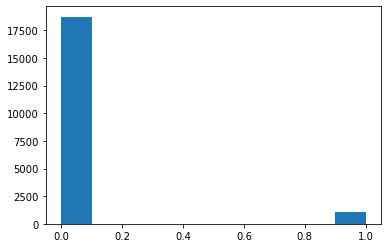

In [5]:
G = nx.read_gml('Graphs/graph_with_normalized_centrality.gml')

class_dataframe = pd.read_csv('Datasets/C0006142_Malignant_neoplasm_of_breast_features.csv')
class_dataframe = dict(zip(class_dataframe['name'], class_dataframe['class']))

labels = []

for node in G:
    labels.append(class_dataframe[node])

labels = np.asarray(labels)

plt.hist(labels)
plt.show()

In [6]:
attributes = ['degree', 'betweenness', 'eigenvector', 'closeness']

dataset_with_norm_centrality = MyDataset(G, labels, attributes, balance=True ,debug=True)
data_with_norm_centrality = dataset_with_norm_centrality[0]

len train_idx: 13832
len test_idx: 2964
len val_idx: 2965
pos/neg in train mask: 717 717
pos/neg in test mask: 154 154
pos/neg in val mask: 154 154


### 2 Layers

  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch: 0000] train loss: 0.6934, train acc: 0.5000, test acc: 0.5000, val loss: 0.6932, val acc: 0.5000  (best train acc: 0.5000, best val acc: 0.5000, best test acc: 0.5000)
[Epoch: 0020] train loss: 0.6930, train acc: 0.5244, test acc: 0.5000, val loss: 0.6931, val acc: 0.5000  (best train acc: 0.5377, best val acc: 0.5682, best test acc: 0.5584)
[Epoch: 0040] train loss: 0.6931, train acc: 0.5195, test acc: 0.5065, val loss: 0.6930, val acc: 0.5000  (best train acc: 0.5509, best val acc: 0.5682, best test acc: 0.5747)
[Epoch: 0060] train loss: 0.6929, train acc: 0.5377, test acc: 0.5390, val loss: 0.6930, val acc: 0.5519  (best train acc: 0.5676, best val acc: 0.5909, best test acc: 0.5747)
[Epoch: 0080] train loss: 0.6929, train acc: 0.5446, test acc: 0.5357, val loss: 0.6930, val acc: 0.5325  (best train acc: 0.5816, best val acc: 0.5942, best test acc: 0.5747)
[Epoch: 0100] train loss: 0.6928, train acc: 0.5718, test acc: 0.5390, val loss: 0.6929, val acc: 0.5519  (best train ac

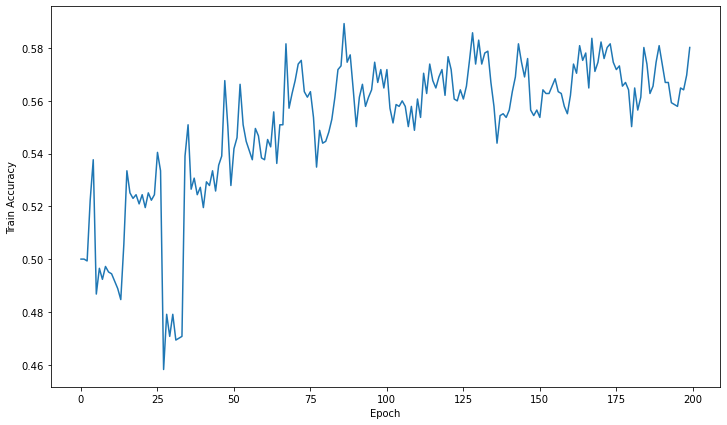

              precision    recall  f1-score   support

           0       0.54      0.50      0.52       154
           1       0.54      0.58      0.56       154

    accuracy                           0.54       308
   macro avg       0.54      0.54      0.54       308
weighted avg       0.54      0.54      0.54       308



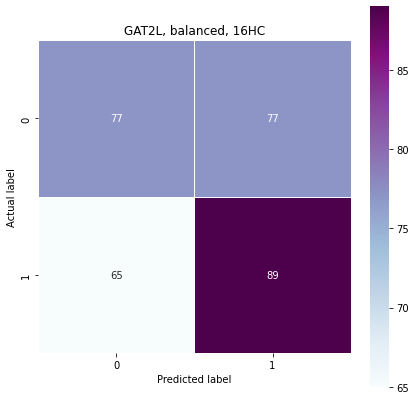

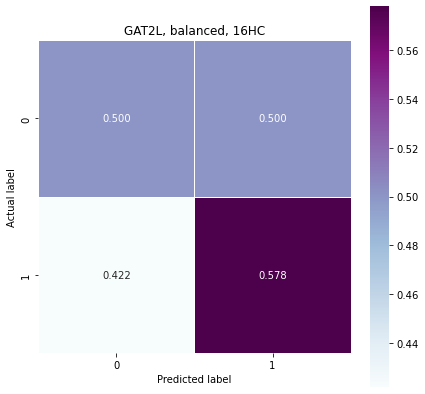

In [7]:
gnn2l = GNN2L_GAT(data_with_norm_centrality).to(device)
pred = train(gnn2l, data_with_norm_centrality.to(device), 200, cm_title='GAT2L, balanced, 16HC')

### 4 Layers

  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch: 0000] train loss: 0.7649, train acc: 0.5000, test acc: 0.5000, val loss: 0.7572, val acc: 0.5000  (best train acc: 0.5000, best val acc: 0.5000, best test acc: 0.5000)
[Epoch: 0020] train loss: 0.6941, train acc: 0.4944, test acc: 0.5000, val loss: 0.6937, val acc: 0.5000  (best train acc: 0.5000, best val acc: 0.5000, best test acc: 0.5000)
[Epoch: 0040] train loss: 0.6939, train acc: 0.5000, test acc: 0.5000, val loss: 0.6938, val acc: 0.5000  (best train acc: 0.5488, best val acc: 0.5065, best test acc: 0.5032)
[Epoch: 0060] train loss: 0.6933, train acc: 0.4770, test acc: 0.5000, val loss: 0.6931, val acc: 0.5000  (best train acc: 0.5488, best val acc: 0.5065, best test acc: 0.5032)
[Epoch: 0080] train loss: 0.6932, train acc: 0.4686, test acc: 0.5000, val loss: 0.6931, val acc: 0.5000  (best train acc: 0.5488, best val acc: 0.5065, best test acc: 0.5032)
[Epoch: 0100] train loss: 0.6931, train acc: 0.5377, test acc: 0.5032, val loss: 0.6931, val acc: 0.5065  (best train ac

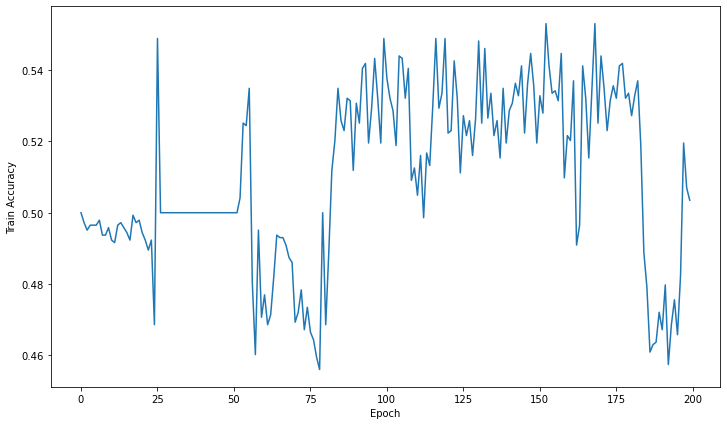

              precision    recall  f1-score   support

           0       1.00      0.03      0.06       154
           1       0.51      1.00      0.67       154

    accuracy                           0.52       308
   macro avg       0.75      0.52      0.37       308
weighted avg       0.75      0.52      0.37       308



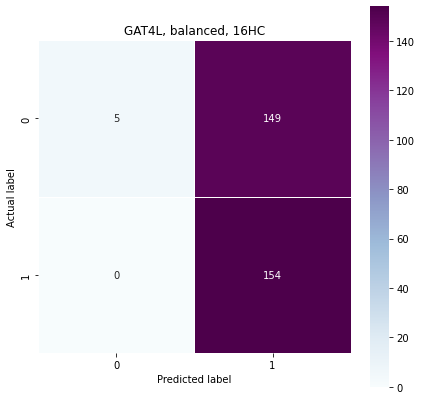

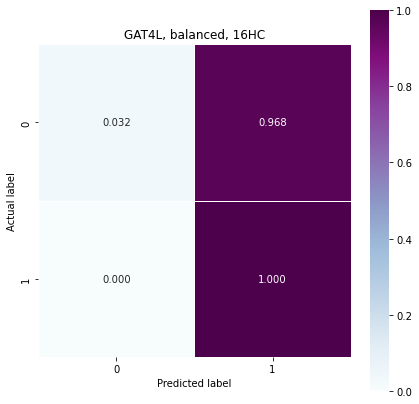

In [8]:
gnn4l = GNN4L_GAT(data_with_norm_centrality).to(device)
pred = train(gnn4l, data_with_norm_centrality.to(device), 200, cm_title='GAT4L, balanced, 16HC')

## NeDBIT Features

In [5]:
attributes = ['degree', 'ring', 'NetRank', 'NetShort', 'HeatDiff', 'InfoDiff']

G_nb = nx.read_gml('Graphs/graph_with_nedbit.gml')

# Take the labels from the class column of the features' file
class_dataframe = pd.read_csv('Datasets/C0006142_Malignant_neoplasm_of_breast_features.csv')
class_dataframe = dict(zip(class_dataframe['name'], class_dataframe['class']))

labels = []

for node in G_nb:
    labels.append(class_dataframe[node])

labels = np.asarray(labels)

len train_idx: 13832
len test_idx: 2964
len val_idx: 2965
pos/neg in train mask: 717 717
pos/neg in test mask: 154 154
pos/neg in val mask: 154 154


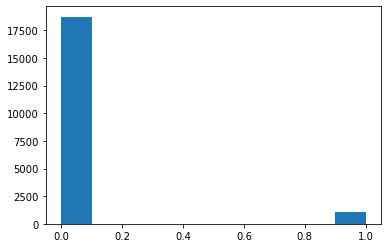

In [6]:
dataset_with_nedbit = MyDataset(G_nb, labels, attributes, balance = True, debug=True)
data_with_nedbit = dataset_with_nedbit[0]

plt.hist(labels)
plt.show()

In [24]:
# Statistiche da commentare
nx.radius(G)

4

In [25]:
# Statistiche da commentare
nx.diameter(G)

7

### 2 Layer

  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch: 0000] train loss: 2.8194, train acc: 0.4986, test acc: 0.5000, val loss: 3.1024, val acc: 0.5000  (best train acc: 0.4986, best val acc: 0.5000, best test acc: 0.5000)
[Epoch: 0020] train loss: 1.5158, train acc: 0.5007, test acc: 0.5000, val loss: 1.7013, val acc: 0.5000  (best train acc: 0.5014, best val acc: 0.5000, best test acc: 0.5000)
[Epoch: 0040] train loss: 0.8724, train acc: 0.5007, test acc: 0.5000, val loss: 0.8822, val acc: 0.5000  (best train acc: 0.5028, best val acc: 0.5000, best test acc: 0.5000)
[Epoch: 0060] train loss: 0.6992, train acc: 0.5056, test acc: 0.5000, val loss: 0.7005, val acc: 0.5000  (best train acc: 0.5418, best val acc: 0.5227, best test acc: 0.5130)
[Epoch: 0080] train loss: 0.6907, train acc: 0.4784, test acc: 0.4968, val loss: 0.6895, val acc: 0.5000  (best train acc: 0.5418, best val acc: 0.5487, best test acc: 0.5422)
[Epoch: 0100] train loss: 0.6899, train acc: 0.4972, test acc: 0.4968, val loss: 0.6886, val acc: 0.5000  (best train ac

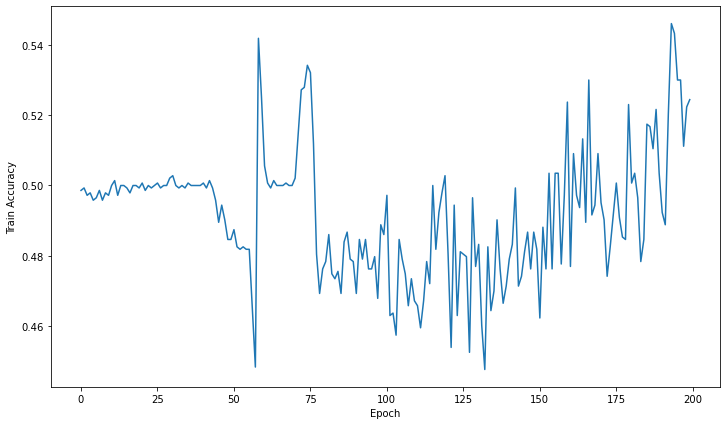

              precision    recall  f1-score   support

           0       0.48      0.79      0.60       154
           1       0.42      0.15      0.22       154

    accuracy                           0.47       308
   macro avg       0.45      0.47      0.41       308
weighted avg       0.45      0.47      0.41       308



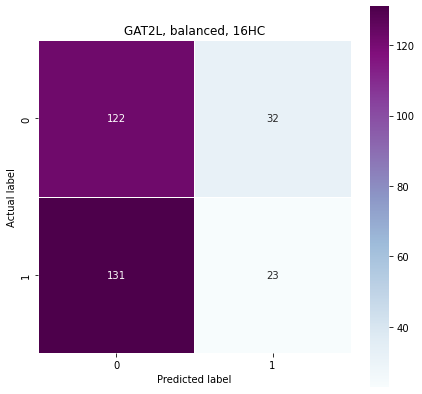

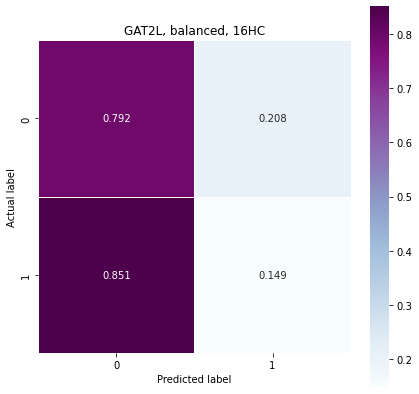

In [7]:
gnn2l_gat = GNN2L_GAT(data_with_nedbit).to(device)
pred = train(gnn2l_gat, data_with_nedbit.to(device), 200, cm_title='GAT2L, balanced, 16HC')

### 4 Layers

  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch: 0000] train loss: 2134.0527, train acc: 0.4930, test acc: 0.5000, val loss: 2100.6340, val acc: 0.5000  (best train acc: 0.4930, best val acc: 0.5000, best test acc: 0.5000)
[Epoch: 0020] train loss: 749.7729, train acc: 0.5105, test acc: 0.5000, val loss: 759.0065, val acc: 0.5000  (best train acc: 0.5244, best val acc: 0.5000, best test acc: 0.5000)
[Epoch: 0040] train loss: 22.5293, train acc: 0.5000, test acc: 0.5000, val loss: 25.9298, val acc: 0.5000  (best train acc: 0.5244, best val acc: 0.5000, best test acc: 0.5000)
[Epoch: 0060] train loss: 41.3649, train acc: 0.5000, test acc: 0.5000, val loss: 35.8721, val acc: 0.5000  (best train acc: 0.5244, best val acc: 0.5000, best test acc: 0.5000)
[Epoch: 0080] train loss: 12.3256, train acc: 0.5000, test acc: 0.5000, val loss: 10.4174, val acc: 0.5000  (best train acc: 0.5244, best val acc: 0.5000, best test acc: 0.5000)
[Epoch: 0100] train loss: 1.5261, train acc: 0.4819, test acc: 0.5000, val loss: 1.2294, val acc: 0.5000

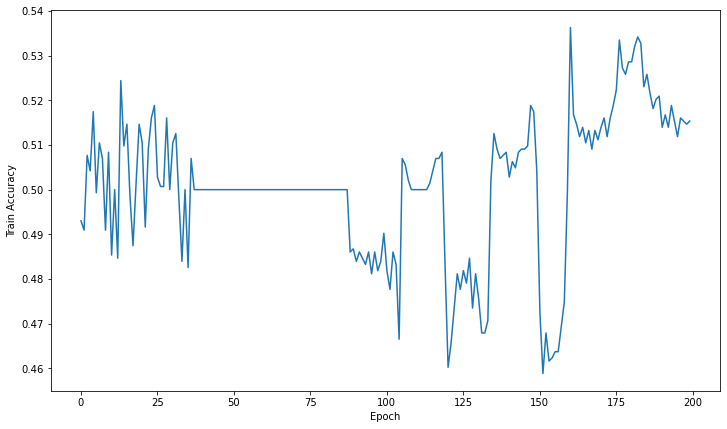

              precision    recall  f1-score   support

           0       0.66      0.18      0.28       154
           1       0.52      0.91      0.67       154

    accuracy                           0.54       308
   macro avg       0.59      0.54      0.47       308
weighted avg       0.59      0.54      0.47       308



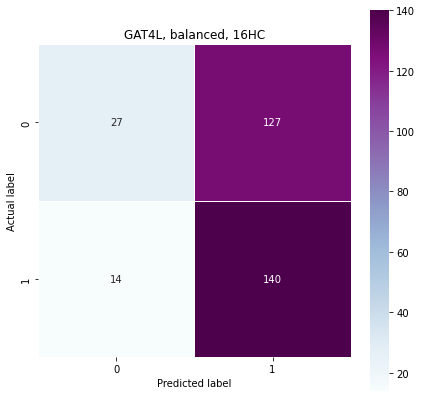

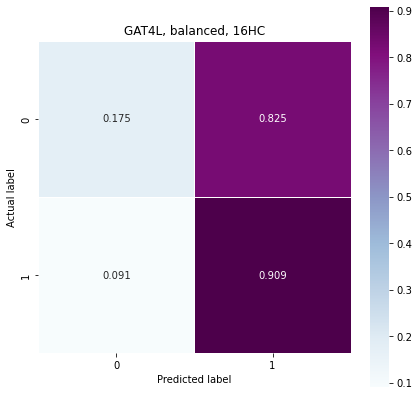

In [8]:
gnn4l_gat = GNN4L_GAT(data_with_nedbit).to(device)
pred = train(gnn4l_gat, data_with_nedbit.to(device), 200, cm_title='GAT4L, balanced, 16HC')

## NeDBIT Features w/ Score

In [5]:
attributes = ['degree', 'ring', 'NetRank', 'NetShort', 'HeatDiff', 'InfoDiff', 'score']

G_nbs = nx.read_gml('Graphs/graph_with_nedbit_score.gml')

# Take the labels from the class column of the features' file
class_dataframe = pd.read_csv('Datasets/C0006142_Malignant_neoplasm_of_breast_features.csv')
class_dataframe = dict(zip(class_dataframe['name'], class_dataframe['class']))

labels = []

for node in G_nbs:
    labels.append(class_dataframe[node])

labels = np.asarray(labels)

len train_idx: 13832
len test_idx: 2964
len val_idx: 2965
pos/neg in train mask: 717 717
pos/neg in test mask: 154 154
pos/neg in val mask: 154 154


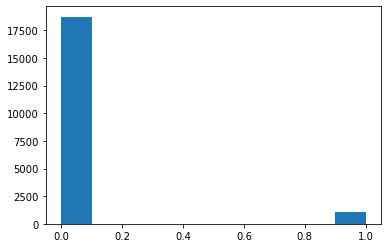

In [6]:
dataset_with_nedbit_score = MyDataset(G_nbs, labels, attributes, balance = True, debug=True)
data_with_nedbit_score = dataset_with_nedbit_score[0]

plt.hist(labels)
plt.show()

### 2 Layers

  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch: 0000] train loss: 1.1820, train acc: 0.5000, test acc: 0.5000, val loss: 3.3919, val acc: 0.5000  (best train acc: 0.5000, best val acc: 0.5000, best test acc: 0.5000)
[Epoch: 0020] train loss: 0.7419, train acc: 0.5370, test acc: 0.5097, val loss: 2.9903, val acc: 0.5032  (best train acc: 0.5453, best val acc: 0.5292, best test acc: 0.5162)
[Epoch: 0040] train loss: 0.7232, train acc: 0.5293, test acc: 0.5162, val loss: 1.5674, val acc: 0.5130  (best train acc: 0.5453, best val acc: 0.5292, best test acc: 0.5162)
[Epoch: 0060] train loss: 0.7054, train acc: 0.5286, test acc: 0.5130, val loss: 1.0325, val acc: 0.5097  (best train acc: 0.5453, best val acc: 0.5292, best test acc: 0.5195)
[Epoch: 0080] train loss: 0.6963, train acc: 0.5119, test acc: 0.4643, val loss: 0.7617, val acc: 0.5000  (best train acc: 0.5453, best val acc: 0.5292, best test acc: 0.5195)
[Epoch: 0100] train loss: 0.6915, train acc: 0.5377, test acc: 0.4708, val loss: 0.7198, val acc: 0.5097  (best train ac

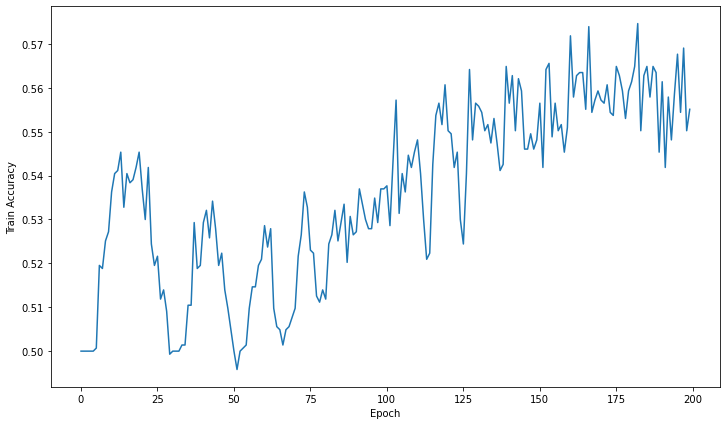

              precision    recall  f1-score   support

           0       0.50      0.89      0.64       154
           1       0.51      0.12      0.19       154

    accuracy                           0.50       308
   macro avg       0.51      0.50      0.42       308
weighted avg       0.51      0.50      0.42       308



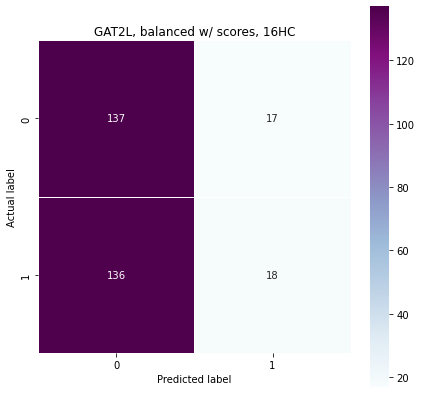

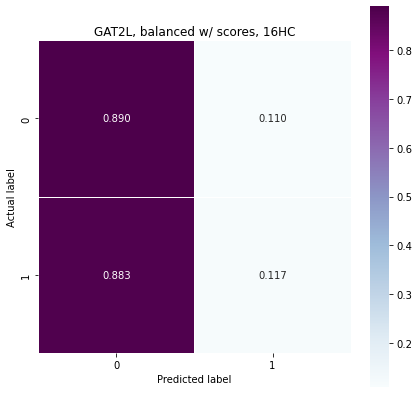

In [7]:
gnn2l_gat = GNN2L_GAT(data_with_nedbit_score).to(device)
pred = train(gnn2l_gat, data_with_nedbit_score.to(device), 200, cm_title='GAT2L, balanced w/ scores, 16HC')

### 4 Layers

  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch: 0000] train loss: 0.7104, train acc: 0.5000, test acc: 0.5000, val loss: 0.7058, val acc: 0.5000  (best train acc: 0.5000, best val acc: 0.5000, best test acc: 0.5000)
[Epoch: 0020] train loss: 0.6948, train acc: 0.4902, test acc: 0.5000, val loss: 0.6952, val acc: 0.4935  (best train acc: 0.5649, best val acc: 0.5617, best test acc: 0.5617)
[Epoch: 0040] train loss: 0.6925, train acc: 0.4861, test acc: 0.4935, val loss: 0.6939, val acc: 0.4773  (best train acc: 0.5704, best val acc: 0.5779, best test acc: 0.5714)
[Epoch: 0060] train loss: 0.6925, train acc: 0.5565, test acc: 0.5552, val loss: 0.6931, val acc: 0.4903  (best train acc: 0.5711, best val acc: 0.5779, best test acc: 0.5714)
[Epoch: 0080] train loss: 0.6824, train acc: 0.5628, test acc: 0.5682, val loss: 0.6773, val acc: 0.5649  (best train acc: 0.5865, best val acc: 0.5779, best test acc: 0.5714)
[Epoch: 0100] train loss: 0.6825, train acc: 0.5530, test acc: 0.5649, val loss: 0.6770, val acc: 0.5812  (best train ac

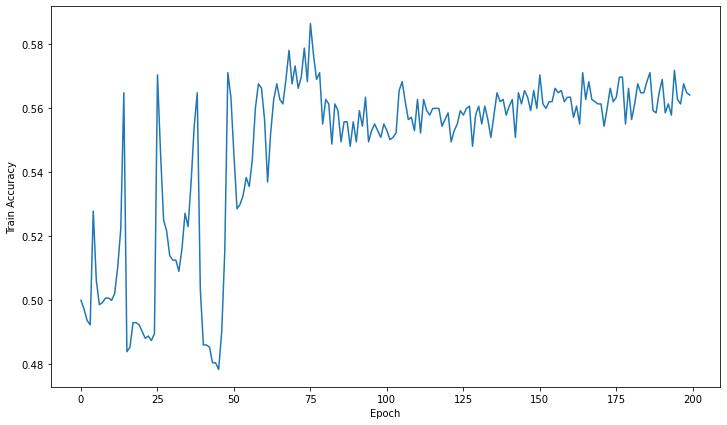

              precision    recall  f1-score   support

           0       0.59      0.35      0.44       154
           1       0.54      0.76      0.63       154

    accuracy                           0.56       308
   macro avg       0.57      0.56      0.54       308
weighted avg       0.57      0.56      0.54       308



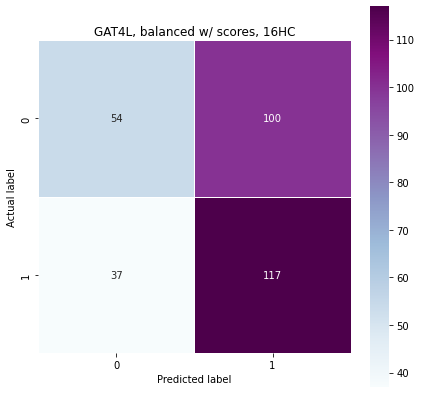

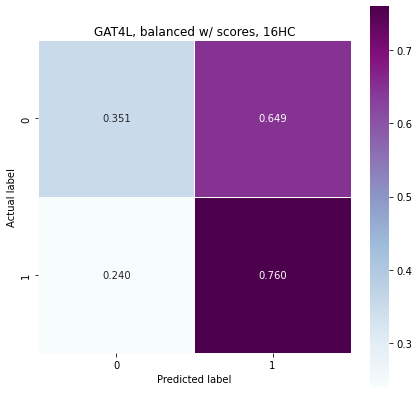

In [8]:
gnn4l_gat = GNN4L_GAT(data_with_nedbit_score).to(device)
pred = train(gnn4l_gat, data_with_nedbit_score.to(device), 200, cm_title='GAT4L, balanced w/ scores, 16HC')

## NeDBIT Multiclass

In [5]:
G = nx.read_gml('Graphs/graph_with_nedbit.gml')

(18736, 2)


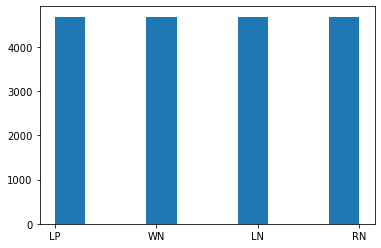

In [6]:
seed_genes          = pd.read_csv('Datasets/C0006142_Malignant_neoplasm_of_breast_seed_genes.txt', header=None, sep=' ')
seed_genes.columns  = ["name", "GDA Score"]
seeds_list          = seed_genes["name"].values.tolist()

nedbit_scores = pd.read_csv('Datasets/C0006142_Malignant_neoplasm_of_breast_features_Score.csv')

# Remove seed genes
nedbit_scores_not_seed = nedbit_scores[~nedbit_scores['name'].isin(seeds_list)]
print(nedbit_scores_not_seed.shape)

# Sort scores for quartile division
nedbit_scores_not_seed = nedbit_scores_not_seed.sort_values(by = "out", ascending = False)
pseudo_labels = pd.qcut(x = nedbit_scores_not_seed["out"], q = 4, labels = ["RN", "LN", "WN", "LP"])

plt.hist(pseudo_labels)
plt.show()

In [7]:
nedbit_scores_not_seed['label'] = pseudo_labels

nedbit_scores_seed = nedbit_scores[nedbit_scores['name'].isin(seeds_list)]
nedbit_scores_seed['label'] = 'P'

# Convert dataframe to dict for searching nodes and their labels
not_seed_labels = dict(zip(nedbit_scores_not_seed['name'], nedbit_scores_not_seed['label']))
seed_labels     = dict(zip(nedbit_scores_seed['name'], nedbit_scores_seed['label']))

labels_dict = {'P':0, 'LP': 1, 'WN': 2, 'LN': 3, 'RN': 4}
labels = []

for node in G:
    if node in not_seed_labels:
        labels.append(labels_dict[not_seed_labels[node]])
    else:
        labels.append(labels_dict[seed_labels[node]])

labels = np.asarray(labels)
len(labels)

C:\Users\pmaur\AppData\Local\Temp\ipykernel_2464\1918763083.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nedbit_scores_seed['label'] = 'P'


19761

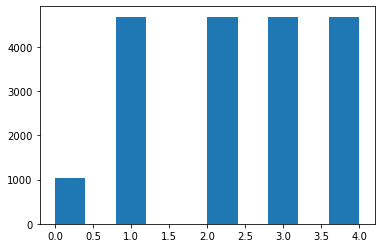

In [8]:
attributes = ['degree', 'ring', 'NetRank', 'NetShort', 'HeatDiff', 'InfoDiff']

dataset_with_nedbit = MyDataset(G, labels, attributes, num_classes=5, balance=False, debug=False)
data_with_nedbit = dataset_with_nedbit[0]

plt.hist(labels)
plt.show()

### 2 Layers

  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch: 0000] train loss: 23.9111, train acc: 0.2370, test acc: 0.2372, val loss: 19.7775, val acc: 0.2371  (best train acc: 0.2370, best val acc: 0.2371, best test acc: 0.2372)
[Epoch: 0020] train loss: 17.3468, train acc: 0.2370, test acc: 0.2372, val loss: 14.2413, val acc: 0.2371  (best train acc: 0.2370, best val acc: 0.2371, best test acc: 0.2372)
[Epoch: 0040] train loss: 12.1319, train acc: 0.2369, test acc: 0.2372, val loss: 9.3867, val acc: 0.2371  (best train acc: 0.2370, best val acc: 0.2371, best test acc: 0.2372)
[Epoch: 0060] train loss: 2.8166, train acc: 0.2368, test acc: 0.2372, val loss: 2.7063, val acc: 0.2371  (best train acc: 0.2371, best val acc: 0.2371, best test acc: 0.2372)
[Epoch: 0080] train loss: 2.1133, train acc: 0.2333, test acc: 0.2372, val loss: 2.2612, val acc: 0.2371  (best train acc: 0.2383, best val acc: 0.2371, best test acc: 0.2372)
[Epoch: 0100] train loss: 2.0112, train acc: 0.2189, test acc: 0.2372, val loss: 2.1548, val acc: 0.2371  (best tra

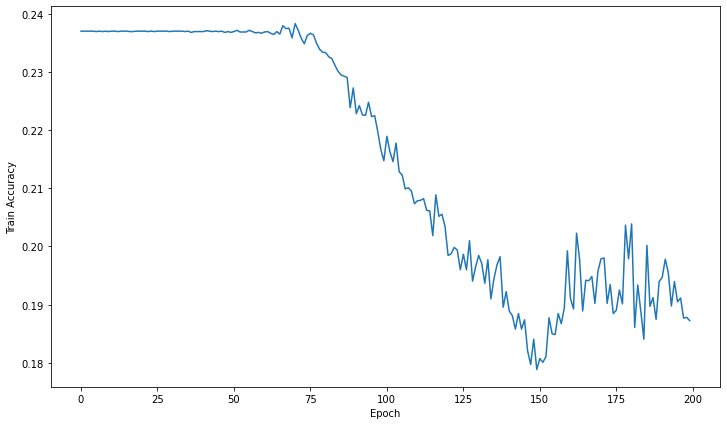

c:\Users\pmaur\miniconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pmaur\miniconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pmaur\miniconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.00      0.00      0.00       703
           2       0.00      0.00      0.00       702
           3       0.24      1.00      0.38       703
           4       0.00      0.00      0.00       702

    accuracy                           0.24      2964
   macro avg       0.05      0.20      0.08      2964
weighted avg       0.06      0.24      0.09      2964



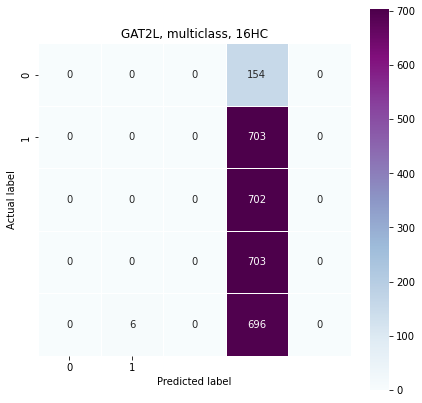

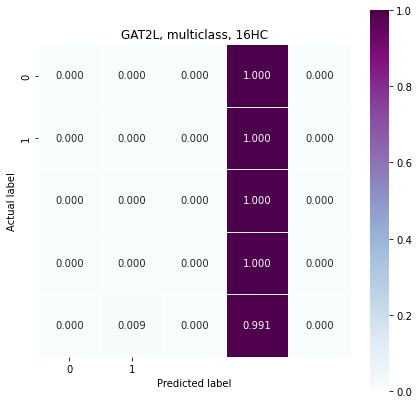

In [13]:
gnn2l_gat = GNN2L_GAT(data_with_nedbit).to(device)
pred = train(gnn2l_gat, data_with_nedbit.to(device), 200, cm_title='GAT2L, multiclass, 16HC')

### 4 Layers

  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 0000] train loss: 5.8440, train acc: 0.0518, test acc: 0.0520, val loss: 5.1691, val acc: 0.0519  (best train acc: 0.0518, best val acc: 0.0519, best test acc: 0.0520)
[Epoch: 0020] train loss: 2.0366, train acc: 0.0526, test acc: 0.0520, val loss: 1.9924, val acc: 0.0519  (best train acc: 0.0532, best val acc: 0.0519, best test acc: 0.0520)
[Epoch: 0040] train loss: 1.7023, train acc: 0.2306, test acc: 0.2368, val loss: 1.6925, val acc: 0.2371  (best train acc: 0.2306, best val acc: 0.2371, best test acc: 0.2368)
[Epoch: 0060] train loss: 1.6102, train acc: 0.2282, test acc: 0.2365, val loss: 1.6050, val acc: 0.2371  (best train acc: 0.2316, best val acc: 0.2371, best test acc: 0.2368)
[Epoch: 0080] train loss: 1.5699, train acc: 0.2642, test acc: 0.2655, val loss: 1.5668, val acc: 0.2678  (best train acc: 0.3055, best val acc: 0.3177, best test acc: 0.3188)
[Epoch: 0100] train loss: 1.5468, train acc: 0.3081, test acc: 0.3198, val loss: 1.5441, val acc: 0.3191  (best train ac

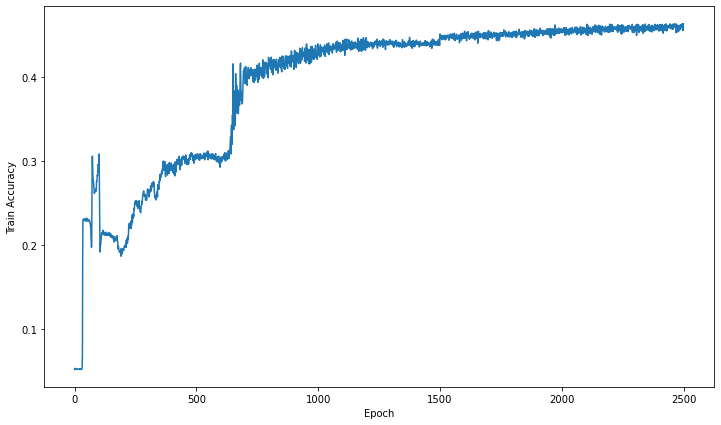

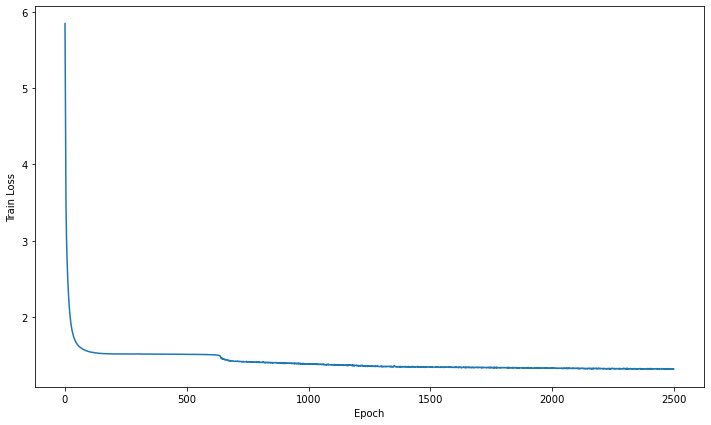

c:\Users\pmaur\miniconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pmaur\miniconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pmaur\miniconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.42      0.78      0.54       703
           2       0.32      0.10      0.16       702
           3       0.42      0.46      0.44       703
           4       0.68      0.63      0.65       702

    accuracy                           0.47      2964
   macro avg       0.37      0.39      0.36      2964
weighted avg       0.43      0.47      0.42      2964



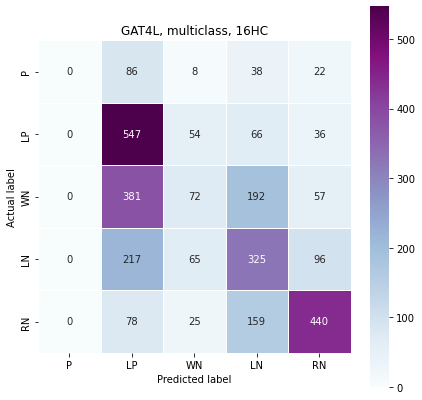

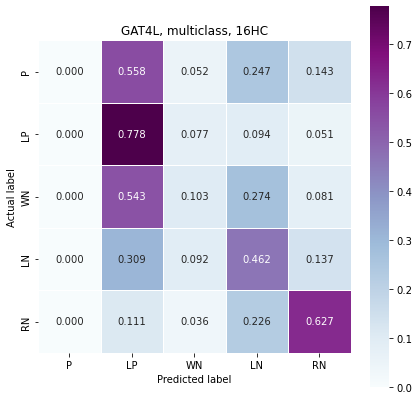

In [9]:
gnn4l_gat = GNN4L_GAT(data_with_nedbit).to(device)
pred = train(gnn4l_gat, data_with_nedbit.to(device), 2500, cm_title='GAT4L, multiclass, 16HC', classes=['P', 'LP', 'WN', 'LN', 'RN'])